# Lab Two: Images!
## Caleb Moore, Christian Gould, and Blake Gebhardt

Data Source: https://www.kaggle.com/datasets/gpreda/chinese-mnist

In [124]:
# Imports
import pandas as pd
import numpy as np
from PIL import Image
import os
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [125]:
# Notebook setup
from IPython.display import HTML
HTML('''<script>
code_show_err=false; 
function code_toggle_err() {
 if (code_show_err){
 $('div.output_stderr').hide();
 } else {
 $('div.output_stderr').show();
 }
 code_show_err = !code_show_err
} 
$( document ).ready(code_toggle_err);
</script>
To toggle on/off output_stderr, click <a href="javascript:code_toggle_err()">here</a>.''')

# 💰 Business Understanding (2 points total).
* Give an overview of the dataset. Describe the purpose of the data set you selected (i.e., why was this data collected in the first place?). What is the prediction task for your dataset and which third parties would be interested in the results? Why is this data important? Once you begin modeling, how well would your prediction algorithm need to perform to be considered useful to the identified third parties? Be specific and use your own words to describe the aspects of the data. 

### Purpose of the Dataset
* The purpose of the dataset is to be able to read and recognize an image of a chineese number, and be able to predict what number it is. This is important because it can be used to help with reading and recognizing numbers from a language that people in America are not very familiar with, and could possibly be used and generalized to other languages.

### Prediction Task
* The prediction task is exactly what the dataset was originally collected for. We want to be able to predict the numbers that are in the images.

### Third Parties
* The third parties that would be interested in the results would be anyone who is a foreigner in china and wants to be able to read and recognize chinese numbers, possibly for paying for services or buying things.

# 📊 Data Preparation

In [126]:
# convert an image name to a python array
def conv_img_name_to_array(img_name):
  returnArr = []

  # Remove the .jpg extension
  img_name = img_name[:-4]

  # Split the string by underscore
  img_name = img_name.split('_')

  returnArr.append(int(img_name[1]))
  returnArr.append(int(img_name[2]))
  returnArr.append(int(img_name[3]))

  return returnArr

* [.5 points] Read in your images as numpy arrays. Resize and recolor images as necessary.

In [127]:
# Function to convert an image to a 1 dimensional array, given the image path
IMG_SIZE = 100

def conv_img_to_array(img_path):
    img = Image.open(img_path)
    # Convert to grayscale
    img = img.convert('L')

    # Adjust the size
    img = img.resize((IMG_SIZE, IMG_SIZE))

    # Convert to numpy array
    img_array = np.array(img)

    # Flatten the array
    img_array = img_array.flatten()
    return img_array

* [.4 points] Linearize the images to create a table of 1-D image features (each row should be one image).   

In [138]:
def conv_data_folder_to_df(df, dataFolderPath, title, limit=None):

    # Create an empty list to store the image arrays
    img_array_list = []

    # Loop over all the images in the folder for limited number of them
    if limit is not None:
        count = 0
        for img_path in os.listdir(dataFolderPath):
            if count == limit:
                break
            # Convert the image to a 1 dimensional array
            img_array = conv_img_to_array(dataFolderPath + img_path)

            # Get the suite_id, sample_id, and code from the image name
            # img_name = conv_img_name_to_array(img_path)

            # Add the suite_id, sample_id, and code to the front of the array
            img_array = np.append(title, img_array)

            # Add it to the list
            img_array_list.append(img_array)
            count += 1

    # Loop over all the images in the folder for all of them
    else:
        for img_path in os.listdir(dataFolderPath):
            # Convert the image to a 1 dimensional array
            img_array = conv_img_to_array(dataFolderPath + img_path)

            # Get the suite_id, sample_id, and code from the image name
            # img_name = conv_img_name_to_array(img_path)

            # Add the suite_id, sample_id, and code to the front of the array
            img_array = np.append(title, img_array)

            # Add it to the list
            img_array_list.append(img_array)

    # Convert the list to a dataframe
    new_one = pd.DataFrame(img_array_list)
    return pd.concat([df,new_one], ignore_index=True)

* [.1 points] Visualize several images.

In [129]:
# Given a flattened array of pixel values, display the image
def visualize_array(img_array):
    # Reshape the array to 64x64
    img_array = img_array.reshape(IMG_SIZE, IMG_SIZE)

    # Convert the array to an image
    img = Image.fromarray(img_array)

    # Display the image
    display(img)

array form:  [111 118 112 ... 223 224 224]


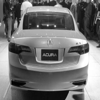

In [130]:
# Visualize an image
img_1 = 'smallSet/first.jpg'
img_1_arr = conv_img_to_array(img_1)
print("array form: ", img_1_arr)
visualize_array(img_1_arr)

array form:  [255 255 255 ... 255 255 255]


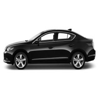

In [131]:
# Visualize another image
img_2 = 'smallSet/second.jpg'
img_2_arr = conv_img_to_array(img_2)
print("array form: ", img_2_arr)
visualize_array(img_2_arr)

array form:  [186 186 182 ... 145 136 135]


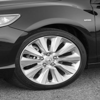

In [132]:
# Visualize a final image
img_3 = 'smallSet/third.jpg'
img_3_arr = conv_img_to_array(img_3)
print("array form: ", img_3_arr)
visualize_array(img_3_arr)

### Read in our image data and csv data

In [140]:
# Convert the data folder to a dataframe
df = pd.DataFrame()
df = conv_data_folder_to_df(df, './training_set/car/', 'car', 5)
df = conv_data_folder_to_df(df, './training_set/flower/', 'flower', 5)
df.head(10)

,0,1,2,3,4,5,6,7,8,9,...,9991,9992,9993,9994,9995,9996,9997,9998,9999,10000
0,car,71,34,60,119,55,104,160,100,70,...,48,65,61,23,54,79,79,36,63,86
1,car,142,117,109,92,108,135,135,194,232,...,3,5,14,11,11,11,13,14,12,10
2,car,149,149,150,150,151,151,151,151,151,...,140,142,141,141,140,138,131,138,150,152
3,car,221,224,225,225,225,228,231,232,232,...,126,147,122,124,114,109,106,109,109,91
4,car,60,64,66,57,29,32,57,61,42,...,169,166,163,161,159,157,157,155,153,153
5,flower,101,117,99,83,109,90,67,85,102,...,92,90,102,111,103,98,87,75,68,67
6,flower,134,134,135,135,135,136,137,137,137,...,156,154,115,128,161,163,167,200,161,220
7,flower,71,71,67,51,41,48,53,55,61,...,62,66,65,57,47,40,34,33,32,31
8,flower,117,117,118,119,120,121,121,121,121,...,98,97,112,124,112,105,90,56,63,68
9,flower,76,77,79,79,79,78,77,76,69,...,149,174,179,179,172,168,159,85,34,35


### Combine the data into one dataframe

In [91]:
# Merge the two dataframes
# data = pd.merge(data_df, csv_df, on=['suite_id', 'sample_id', 'code'])
# data.head()

### Take a brief look at the data

In [ ]:
print('data shape', data.shape)
print()
num_vars = data.columns [data.dtypes != 'object']
cat_vars = data.columns [data.dtypes == 'object']
print ('numerical:', num_vars.values)
print()
print('categorical:', cat_vars.values)
data.dtypes

data shape (15000, 4101)

numerical: ['suite_id' 'sample_id' 'code' ... 'pixel_4094' 'pixel_4095' 'value']

categorical: ['character']


suite_id       int64
sample_id      int64
code           int64
pixel_0        int64
pixel_1        int64
               ...  
pixel_4093     int64
pixel_4094     int64
pixel_4095     int64
value          int64
character     object
Length: 4101, dtype: object

### [1.5 points] Data Reduction 👌: 
<span style="color:red">
[.5 points] Perform linear dimensionality reduction of the images using principal components analysis. Visualize the explained variance of each component. Analyze how many dimensions are required to adequately represent your image data. Explain your analysis and conclusion.
</span>

In [ ]:
# Standardize the data
scaler = StandardScaler()

x = data.loc[:, colNames].values

y = data.loc[:,['character']].values

x = scaler.fit_transform(x)

pca = PCA(n_components=.95)

principalComponents = pca.fit_transform(x)

principalDf = pd.DataFrame(data = principalComponents)

finalDf = pd.concat([principalDf, data[['character']]], axis = 1)

Text(0.5, 1.0, 'PCA')

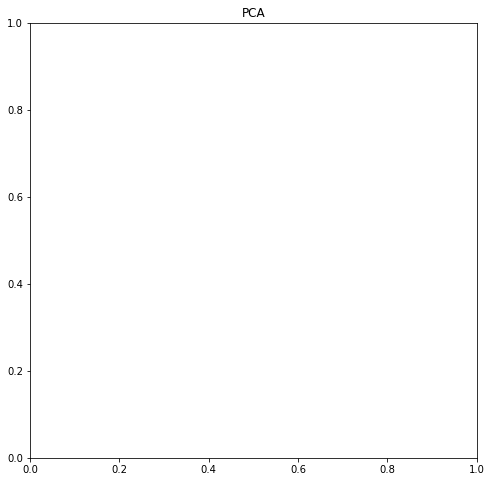

In [ ]:
# Visualize the data
plt.figure(figsize=(8,8))
plt.title('PCA')



<span style="color:red">
[.5 points] Perform linear dimensionality reduction of your image data using randomized principle components analysis. Visualize the explained variance of each component. Analyze how many dimensions are required to adequately represent your image data. Explain your analysis and conclusion.
</span>

<span style="color:red">
[2 points]  Compare the representation using PCA and Randomized PCA. The method you choose to compare dimensionality methods should quantitatively explain which method is better at representing the images with fewer components.  Do you prefer one method over another? Why?
</span>

<span style="color:red">
[1 points] Perform feature extraction upon the images using DAISY. Try different parameters for your image data.
</span>

<span style="color:red">
[2 points] Does this feature extraction method show promise for your prediction task? Why?
</span>

<span style="color:red">
* Use visualizations to analyze this questions. For example, use a heat map of the pairwise differences (ordered by class) among all extracted features. Another option, build a nearest neighbor classifier to see actual classification performance.  
</span>

# Exceptional Work (1 points total)
<span style="color:red">
(0.4) The overall quality of the report as a coherent, useful, and polished product will be reflected here. Does it make sense overall? Do your visualizations answer the questions you put forth in your business analysis? Do you properly and consistently cite sources and annotate changes made to base code? Do you provide specific reasons for your assumptions? Do subsequent questions follow naturally from initial exploration?
</span>


<span style="color:red">
(0.6) Additional analysis
(5000 level) You have free rein to provide any additional analyses and visualizations appropriate to your data.
</span>